In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.close("all")

In [2]:
train_df=pd.read_csv('./data/train_v1.csv')
test_df=pd.read_csv('./data/test_v1_periods.csv')#按0.5h计算
test_day=pd.read_csv('./data/test_v1_day.csv')#按天计算
wkd_df=pd.read_csv('./data/wkd_v1.csv')
wkd_df=wkd_df.rename(columns={'ORIG_DT':'date'})
train_df=train_df.merge(wkd_df)

In [4]:
#将A/B岗位拆分出来分别分析，以天为粒度
tmp=train_df[['date','post_id','amount']].groupby(['date','post_id'],sort=False).agg('sum')
train_day_df=pd.DataFrame(tmp).reset_index()
train_day_df_A=train_day_df[train_day_df['post_id']=='A'].reset_index(drop=True)
train_day_df_B=train_day_df[train_day_df['post_id']=='B'].reset_index(drop=True)
train_day_df_A=train_day_df_A.merge(wkd_df)
train_day_df_B=train_day_df_B.merge(wkd_df)
#
def get_frt(df):
    df['WKD_TYP_CD']=df['WKD_TYP_CD'].map({'WN':0,'SN': 1, 'NH': 1, 'SS': 1, 'WS': 0})
    month=[]
    day=[]
    year=[]
    dates=df['date'].values
    for date in dates:
        year.append(int(date.split('/')[0]))
        month.append(int(date.split('/')[1]))
        day.append(int(date.split('/')[2]))
    df['year']=year
    df['month']=month
    df['day']=day
    df.drop(['date','post_id'],axis=1,inplace=True)
    return df
train_day_df_A=get_frt(train_day_df_A)
train_day_df_B=get_frt(train_day_df_B)
train_day_df_A['amount']=train_day_df_A['amount']/1e4
train_day_df_B['amount']=train_day_df_B['amount']/1e4

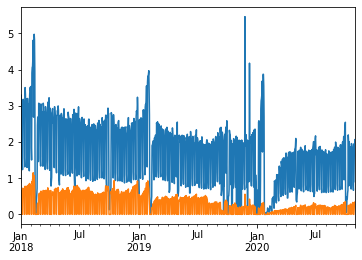

In [6]:
ts = pd.Series(train_day_df_A['amount'].values, index=pd.date_range("1/1/2018", periods=len(train_day_df_A['amount'].values)))
ts.plot()
ts = pd.Series(train_day_df_B['amount'].values, index=pd.date_range("1/1/2018", periods=len(train_day_df_B['amount'].values)))
ts.plot()

对于A：
- 可以看到18/10--18/11月增加了(59.1890-54.6016)/54.6016=8.4%
- 可以看到19/10--19/11月增加了(46.6275-44.9047)/44.9047=3.8%

对于B:
- 可以看到18/10--18/11月增加了(12.88-11.72)/11.72=9.9%
- 可以看到19/10--19/11月增加了(3.793-3.625)/3.625=4.6%
18-19年月份之间的趋势变化基本一致，20年因为疫情影响，数值的绝对值在变化，
但是趋势并未变化，如果以年份来看的话周期性十分明显。

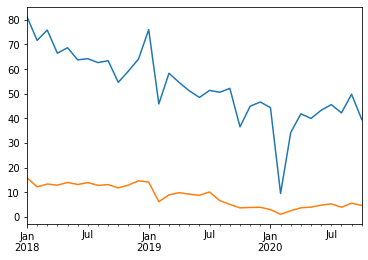

In [7]:
#A按照year/month进行group,看看每一年中每一个月的变化
group_year_month_A=train_day_df_A[['year','month','amount']].groupby(['year','month'],sort=False).agg(['sum'])
group_year_month_A=pd.DataFrame(group_year_month_A).reset_index()
group_year_month_A.columns=['year','month','amount']
ts = pd.Series(group_year_month_A['amount'].values, index=pd.date_range("1/2018", periods=len(group_year_month_A['amount'].values),freq="M"))
ts.plot()
#B按照year/month进行group,看看每一年中每一个月的变化
group_year_month_B=train_day_df_B[['year','month','amount']].groupby(['year','month'],sort=False).agg(['sum'])
group_year_month_B=pd.DataFrame(group_year_month_B).reset_index()
group_year_month_B.columns=['year','month','amount']
ts = pd.Series(group_year_month_B['amount'].values, index=pd.date_range("1/2018", periods=len(group_year_month_B['amount'].values),freq="M"))
ts.plot()

## 分析18/19两年11月份的每一天的趋势

- 如果只看day和amount的趋势，18/19各自11月份的变化趋势和天数关系其实不大
- 但通过分析WKD_TYP_CD可以明显看到，11月份只有两种WKD_TYP_CD:WN/SN，当为WN时，业务量明显高于SN.这也是符合常识的
- 20年11月份的WKD_TYP_CD也只有WN/SN两种情形，所以我们只需要考虑WN和SN对amount的影响
  - 这里最朴素的想法是统计18，19年11月0,1对应的每一天的amount占一个月的比例

0.03926397564658053
0.0415190392097041
0.017024066971903562
0.014233352955134861


'\n0.03926397564658053\n0.0415190392097041\n0.017024066971903562\n0.014233352955134861\n所以如果得到20年11月份的总业务量nov_2020\nnov_2020*(0.039+0.041)/2 if 当前day的WKD_TYP_CD==0\nnov_2020*(0.017+0.014)/2 if 当前day的WKD_TYP_CD==1\n'

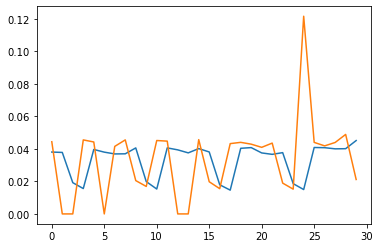

In [8]:
nov_month=train_day_df_A[train_day_df_A['month']==11]
nov_month_18=nov_month[nov_month['year']==2018][['WKD_TYP_CD','amount']].reset_index(drop=True)
nov_month_19=nov_month[nov_month['year']==2019][['WKD_TYP_CD','amount']].reset_index(drop=True)
nov_month_18['amount']/=np.sum(nov_month_18['amount'])
nov_month_19['amount']/=np.sum(nov_month_19['amount'])
nov_month_18['amount'].plot()
nov_month_19['amount'].plot()
print(nov_month_18[nov_month_18['WKD_TYP_CD']==0]['amount'].mean())
print(nov_month_19[nov_month_19['WKD_TYP_CD']==0]['amount'].mean())
print(nov_month_18[nov_month_18['WKD_TYP_CD']==1]['amount'].mean())
print(nov_month_19[nov_month_19['WKD_TYP_CD']==1]['amount'].mean())
'''
0.03926397564658053
0.0415190392097041
0.017024066971903562
0.014233352955134861
所以如果得到20年11月份的总业务量nov_2020
nov_2020*(0.039+0.041)/2 if 当前day的WKD_TYP_CD==0
nov_2020*(0.017+0.014)/2 if 当前day的WKD_TYP_CD==1
'''

## 规则法建模

经过上面的分析其实可以看出来数据规律性极强，辅以一定简单的模型和规则就可以取得很好的效果，这里点到为止咯，大家自己项怎么利用数据的规律
。目前利用**数据规律+一定的规则**可以得到的分数:
- 任务一: 0.09
- 任务二: 0.23

## LSTM的baseline
用LSTM的方法。
- 任务一: 0.9
- 任务二: 1.2

**远不如直接利用数据规律+一定的规则来做**；
这里还是给出基于LSTM的代码以供参考，但不建议使用，只要是为了给那些还不会利用LSTM建模时序问题的伙伴参考以下

而且**LSTM的建模思路**还是值得学习的，这里给出我自己的构造思路

- 输入序列长度为30day,需要预测的长度也为30day.序列-->>序列
- 序列中每一个输入的维度(即我们构造的特征):[ 当天的业务量，month，day,WKD_TYP_CD)
- 用1月份预测2月；2月预测3月.....10月就预测11月
- 为了充分利用WKD_TYP_CD特征，因为这个特征太重要了，所以可以在解码的时候将该特征embeding进去

**举例**:
- LSTM的输入是9月份的30天amount值，以及这30天的month,day,WKD_TYP_CD特征
- LSTM的输出是10月份的30天的amount值
- 在LSTM解码的时候将10月份的WKD_TYP_CD特征embeding到网络里面和编码器的输出结合。

In [ ]:
from torch.utils.data import Dataset,DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import tushare as ts
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
#

train_df=pd.read_csv('./data/train_v1.csv')
test_df=pd.read_csv('./data/test_v1_periods.csv')#按0.5h计算
test_day=pd.read_csv('./data/test_v1_day.csv')#按天计算
wkd_df=pd.read_csv('./data/wkd_v1.csv')
wkd_df=wkd_df.rename(columns={'ORIG_DT':'date'})
train_df=train_df.merge(wkd_df)
#
#将A/B岗位拆分出来分别建模预测，注意这里取了一天的总量，暂时不考虑细粒度预测
tmp=train_df[['date','post_id','amount']].groupby(['date','post_id'],sort=False).agg('sum')
train_day_df=pd.DataFrame(tmp).reset_index()
train_day_df_A=train_day_df[train_day_df['post_id']=='A'].reset_index(drop=True)
train_day_df_B=train_day_df[train_day_df['post_id']=='B'].reset_index(drop=True)
train_day_df_A=train_day_df_A.merge(wkd_df)
train_day_df_B=train_day_df_B.merge(wkd_df)
#
def get_frt(df):
    df['WKD_TYP_CD']=df['WKD_TYP_CD'].map({'WN':0,'SN': 1, 'NH': 2, 'SS': 3, 'WS': 4})
    month=[]
    day=[]
    dates=df['date'].values
    for date in dates:
        month.append(date.split('/')[1])
        day.append(date.split('/')[2])
    df['month']=month
    df['day']=day
    df.drop(['date','post_id'],axis=1,inplace=True)
    return df
train_day_df_A=get_frt(train_day_df_A)
train_day_df_B=get_frt(train_day_df_B)
train_day_df_A['amount']=train_day_df_A['amount']/1e4
train_day_df_B['amount']=train_day_df_B['amount']/1e4
#
class bankDataset(Dataset):
    def __init__(self,train_len=60,pre_len=30,AB='A'):
        '''
        train_len:构建训练集的滑动窗口长度,以天为单位
        pre_len:需要预测的天数,以天为单位
        AB:训练A/B岗的模型
        '''
        super().__init__()
        self.train_len=train_len
        self.pre_len=pre_len
        if AB=='A':
            #加载A数据
            df=train_day_df_A
        else:
            df=train_day_df_B
        #
        self.labels = df['amount']
        self.train_data= df
        self.Len=len(self.labels)
        self.starts=[i*30 for i in range(31)]
    #
    def __len__(self):
        return len(self.labels)#总共的天数
    
    def __getitem__(self, idx):
        #随机起点截断
        start_point=np.random.choice(self.starts)
        #训练样本,
        train_x = self.train_data.iloc[start_point: start_point+self.train_len].values
        train_y = self.labels[start_point+self.train_len:start_point+self.train_len+self.pre_len].values
        train_y_attention=self.train_data[['month','day','WKD_TYP_CD']].iloc[start_point+self.train_len:start_point+self.train_len+self.pre_len].values
        train_x_attention=self.train_data[['amount']].iloc[start_point: start_point+self.train_len].values
        #
        train_x=torch.from_numpy(train_x.astype(np.float32))
        train_y=torch.from_numpy(train_y.astype(np.float32))
        train_x_attention=torch.from_numpy(train_x_attention.astype(np.float32))
        train_y_attention=torch.from_numpy(train_y_attention.astype(np.float32))
        attention=torch.cat([train_x_attention,train_y_attention],dim=1).reshape(1,-1)
        #
        return train_x, train_y,attention
#
class Model(nn.Module):
    def __init__(self,input_dim=4,out_dim=30):
        super(Model, self).__init__()
        self.lstm_layer = nn.LSTM(input_size=input_dim, hidden_size=64, batch_first=True)
        self.linear_layer = nn.Linear(in_features=64, out_features=out_dim, bias=True)
        self.attention = nn.Sequential(
             nn.Dropout(p=0.5),
             nn.Linear(120, 30),
             nn.ReLU(),
             nn.Dropout(p=0.5),
             nn.Linear(30, out_dim),
        )
    def forward(self, x,att):
        #
        '''
        这里本来应该搭建一个LSTM-Encoder以及一个LSTM-Decoder，因为WKD_TYP_CD是一个
        重要的特征，而11月份的WKD_TYP_CD特征是已知的，所以在解码的时候可以将这个特征
        利用attention的方式加上去。这里为了简化模型，将decoder部分省略掉，WKD_TYP_CD的使用也不是
        attention机制，而是直接使用全连接来提取了特征进行单独预测再和LSTM的预测结合起来
        '''
        out1, (h_n, h_c) = self.lstm_layer(x)
        a, b, c = h_n.shape
        out2 = self.linear_layer(h_n.reshape(a*b, c))
        out_att=self.attention(att)
        return out2+out_att

#
def train_model(max_epoch, train_loader,AB='A'):
    # 训练模型
    best_model = None
    train_loss = 0
    epoch_cnt = 0
    for epoch in range(max_epoch):
        total_train_loss = []
        total_train_num = 0
        for i, data in enumerate(train_loader):
            x,y,attention=data
            #print(x.shape,y.shape)
            x_num = len(x)
            p = model(x,attention)
            loss = loss_func(p, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss.append(loss.item())
            #
        train_loss = np.mean(total_train_loss)
        print('epoch-{} train_loss:{}'.format(epoch,train_loss))
        if epoch%10==0:
            torch.save(model.state_dict(), './ckpt/lstm'+'_epoch_'+AB+str(epoch)+'.pth')
#
if __name__ == '__main__':
    # 参数
    max_epoch = 101
    input_dim=4
    out_dim=30
    batch_size = 16
    AB='A'
    if not os.path.exists('ckpt/'):
        os.makedirs('ckpt/')
    # 初始化模型
    model = Model(input_dim=4,out_dim=30)
 
    # 数据处理部分
    train_dataset = bankDataset(train_len=30,pre_len=30,AB=AB)
    train_loader = DataLoader(train_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=0)
    #

    # 损失函数和优化器
    loss_func = nn.MSELoss()#SmoothL1Loss()#nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=3e-4)
    train_model(max_epoch, train_loader,AB=AB)

epoch-0 train_loss:13.35070226742671
epoch-1 train_loss:3.032626564686115
epoch-2 train_loss:1.5427961019369272
epoch-3 train_loss:1.1438380837440492
epoch-4 train_loss:0.9263771442266611
epoch-5 train_loss:0.7648677725058336
epoch-6 train_loss:0.7380401716782496
epoch-7 train_loss:0.6677222279401925
epoch-8 train_loss:0.6176427456048819
epoch-9 train_loss:0.5791848086393796
epoch-10 train_loss:0.5528260377737192
epoch-11 train_loss:0.5250600571815784
epoch-12 train_loss:0.4953721509529994
epoch-13 train_loss:0.4768508085837731
epoch-14 train_loss:0.43078980170763453
epoch-15 train_loss:0.3963539570569992
epoch-16 train_loss:0.36954775085816016
epoch-17 train_loss:0.34626700167472546
epoch-18 train_loss:0.3455156729771541
epoch-19 train_loss:0.2938799291849136
epoch-20 train_loss:0.2802966578648641
epoch-21 train_loss:0.26006039083003996
epoch-22 train_loss:0.24893111999218281
epoch-23 train_loss:0.22620911850379063
epoch-24 train_loss:0.2079131633043289
epoch-25 train_loss:0.195167677

In [14]:
#
weight_path_A='./ckpt/lstm_epoch_A100.pth'
model_A=Model(input_dim=4,out_dim=30)
model_A.load_state_dict(torch.load(weight_path_A))
model_A.eval()
#
weight_path_B='./ckpt/lstm_epoch_B50.pth'
model_B=Model(input_dim=4,out_dim=30)
model_B.load_state_dict(torch.load(weight_path_B))
model_B.eval()
#
test_df=pd.read_csv('./data/test_v1_periods.csv')#按0.5h计算
test_day=pd.read_csv('./data/test_v1_day.csv')#按天计算
#将A/B岗位拆分出来分别建模预测，注意这里取了一天的总量，暂时不考虑细粒度预测
tmp=test_df[['date','post_id']].groupby(['date','post_id'],sort=False).agg('sum')
test_day_df=pd.DataFrame(tmp).reset_index()
test_day_df_A=test_day_df[test_day_df['post_id']=='A'].reset_index(drop=True)
test_day_df_B=test_day_df[test_day_df['post_id']=='B'].reset_index(drop=True)
test_day_df_A=test_day_df_A.merge(wkd_df)
test_day_df_B=test_day_df_B.merge(wkd_df)
test_day_df_A=get_frt(test_day_df_A)
test_day_df_B=get_frt(test_day_df_B)
#------
def predict(test_day_df_AB,train_day_df_AB):
    test_data=torch.from_numpy(train_day_df_AB[-30:].values.astype(np.float32))
    test_att_x=torch.from_numpy(train_day_df_AB[['amount']][-30:].values.astype(np.float32))
    test_att_y=torch.from_numpy(test_day_df_AB[['month','day','WKD_TYP_CD']].values.astype(np.float32))
    test_att=torch.cat([test_att_x,test_att_y],dim=1).reshape(1,-1)
    test_data=test_data.unsqueeze(0)
    test_att=test_att.unsqueeze(0)
    print(test_data.shape,test_att.shape)
    return test_data,test_att
#
x1,x2=predict(test_day_df_A,train_day_df_A)
pre_A=model_A(x1,x2).detach().numpy()[0][0]
x1,x2=predict(test_day_df_B,train_day_df_B)
pre_B=model_B(x1,x2).detach().numpy()[0][0]
print(pre_A.mean(),pre_B.mean())

torch.Size([1, 30, 4]) torch.Size([1, 1, 120])
torch.Size([1, 30, 4]) torch.Size([1, 1, 120])
2.2529144 0.4464044


In [15]:
test_df=pd.read_csv('./data/test_v1_periods.csv')#按0.5h计算
test_day=pd.read_csv('./data/test_v1_day.csv')#按天计算
#
pre_day=[]
for i in range(30):
    pre_day.append(pre_A[i]*1e4)
    pre_day.append(pre_B[i]*1e4)
test_day['amount']=pre_day
#
if not os.path.exists('submit/'):
    os.makedirs('submit/')

In [17]:
#
f=open('submit/test_day_lstm.txt','w')
f.write('Date'+','+'Post_id'+','+'Predict_amount'+'\n')
for _,date,post_id,amount in test_day.itertuples():
    f.write(date+','+post_id+','+str(int(amount))+'\n')
f.close()